## Doing the regressions

In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
from stargazer.stargazer import Stargazer

xr.set_options(display_expand_attrs=False, display_expand_data=False)
np.set_printoptions(threshold=10, edgeitems=2)

In [3]:
data = pd.read_csv('data.csv')
data.head()

,time,region,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,coef,Run,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,...,log_temperature_change,log_coef,log_total_damage,pop_est_x,index_x,pop_est_y,REGIONS 35 I_x,index_y,pop_est,REGIONS 35 I_y
0,2005.0,BELGIUM,-2.120837,14345.919289,1.714491,0.484972,0,0.845,458081.623996,24767.399895,...,-0.168419,-0.723664,6.120868,NaN,Belgium,11484055.0,BELGIUM,Belgium,11484055.0,BELGIUM
1,2005.0,BULGARIA,-2.120837,14345.919289,1.714491,3.328578,0,0.845,49342.067424,4290.060541,...,-0.168419,1.202545,5.818807,NaN,Bulgaria,6975761.0,BULGARIA,Bulgaria,6975761.0,BULGARIA
2,2005.0,CROATIA,-2.120837,14345.919289,1.714491,1.784685,0,0.845,49378.731850,7565.730576,...,-0.168419,0.579242,5.196246,NaN,Croatia,4067500.0,CROATIA,Croatia,4067500.0,CROATIA
3,2005.0,CYPRUS,-2.120837,14345.919289,1.714491,0.828186,0,0.845,20251.576648,15217.411656,...,-0.168419,-0.188518,3.537200,NaN,Cyprus,1198575.0,CYPRUS,Cyprus,1198575.0,CYPRUS
4,2005.0,DENMARK,-2.120837,14345.919289,1.714491,0.413845,0,0.845,296616.284738,28613.689785,...,-0.168419,-0.882264,5.527660,NaN,Denmark,5818553.0,DENMARK,Denmark,5818553.0,DENMARK


In [4]:
df_melted = pd.read_csv('df_melted.csv')
df_melted.shape

(80055, 12)

### General model

As explained in the conceptual framework, our goal here is to quantifiy how important are each factors in terms of explaining the variation of the explained variable. 

We have distinguished three types of parameters : 

- **physical parameters**, such as temperature, carbon dioxyide concentration, radiative forcing, etc. These directly represent the physical aspect of climate change
- **methodological parameters**, such as the model used, the number of variables, the level of complexity, etc. These represent parameters that rely with the model, from a technical prospective
- **ethical parameters**, such as the discount rate, the normalisation factor or other parameters that take account of ethical considerations

We argue that an integrated assessment model is composed of these three types of parameters. The role of physical variables in the functionning of the model is its primary purpose; the variation between one model and another one has been widely discussed and quantified in the litterature. However, we believe that the ethical variables play a significant role in the determination of the output of the model. 

Hence, we define an econometric model to asses the role of each of the variables in the output of the model. 

The explained variable is the level of damage. Indeed, it is the primary goal of damage functions to assess the level of damages, so we have comparable values  accros models. Moreover, it is a quantified value, so it allows a quantitative evaluation. 

We consider a linear model. The explained variables are a combination of physical, methodological and ethical variables. 

In [5]:
# Regressing
reg_simple = sm.OLS(data['log_total_damage'], sm.add_constant(data[['temperature_change', 'coef']])).fit()
reg_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_total_damage   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                 1.856e+04
Date:                Wed, 11 Sep 2024   Prob (F-statistic):               0.00
Time:                        10:58:23   Log-Likelihood:            -1.3405e+05
No. Observations:               64305   AIC:                         2.681e+05
Df Residuals:                   64302   BIC:                         2.681e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.6729      0.029     92.452      0.000       2.616       2.730
temperature_change     2.6872      0.018    152.005      0.000       2.653       2.722
coef                   0.8873      0.008    113.456      0.000       0.872       0.903
==============================================================================
Omnibus:                     2551.515   Durbin-Watson:                   1.217
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2867.435
Skew:                           0.516   Prob(JB):                         0.00
Kurtosis:                       3.058   Cond. No.                         9.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# Adding a dummy for the equation 
data_dummy = pd.get_dummies(data, columns=['equation'], drop_first=True)
dummy_equations = [col for col in data_dummy.columns if 'equation_' in col]
data_dummy[dummy_equations] = data_dummy[dummy_equations].astype('int')

# Adding a dummy for the region
data_dummy = pd.get_dummies(data_dummy, columns=['region'], drop_first=True)
dummy_regions = [col for col in data_dummy.columns if 'region_' in col]
data_dummy[dummy_regions] = data_dummy[dummy_regions].astype('int')

# Est-ce que c'est un problème de retirer la première valeur à chaque fois ? ca veut dire qu'on retire quand même un tiers des données => en fait non parce que les dummy sont en colonnes et pas en ligne

# Regressing
reg_equation = sm.OLS(data_dummy['log_total_damage'], sm.add_constant(data_dummy[['temperature_change', 'coef'] + dummy_equations])).fit()
reg_equation.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_total_damage   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     9664.
Date:                Wed, 11 Sep 2024   Prob (F-statistic):               0.00
Time:                        10:58:23   Log-Likelihood:            -1.3356e+05
No. Observations:               64305   AIC:                         2.671e+05
Df Residuals:                   64300   BIC:                         2.672e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            2.5401      0.031     82.877      0.000       2.480       2.600
temperature_change                               2.6872      0.018    153.152      0.000       2.653       2.722
coef                                             0.8873      0.008    114.312      0.000       0.872       0.903
equation_dice_tot_eq_dice_total_impact          -0.0686      0.019     -3.676      0.000      -0.105      -0.032
equation_witness_tot_eq_witness_total_impact     0.4669      0.019     25.030      0.000       0.430       0.503
==============================================================================
Omnibus:                     2652.573   Durbin-Watson:                   1.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2994.529
Skew:                           0.528   Prob(JB):                         0.00
Kurtosis:                       3.062   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Explaining the level of damage as a linear model of temperature change, the model choice and the ethical coefficient, is a very weak explanation. We obtain a R2 of 0.073, which is very low and let us think there is absolutely no relationship between the level of damage and the explaining variables. 

This is to be further investigated, since we know there is a relationship between these two : at least, there is a relationship between climate variable such as temperature change, and the level of damage. 

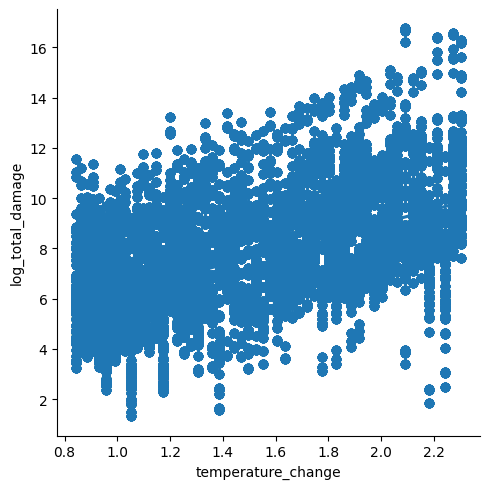

In [7]:
sns.lmplot(x='temperature_change', y='log_total_damage', data=data_dummy)

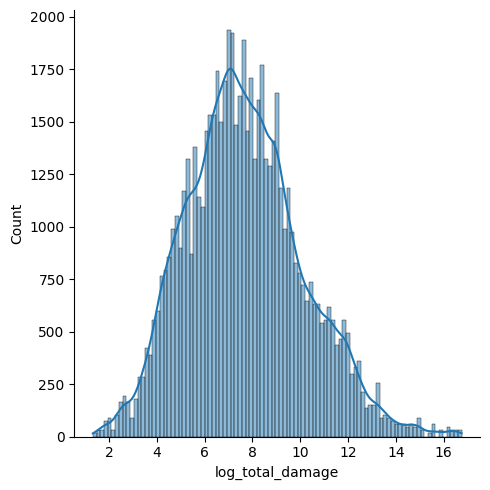

In [8]:
#damage_high = data[data['total_damage'] < 10000]
sns.displot(data, x='log_total_damage', kde=True)

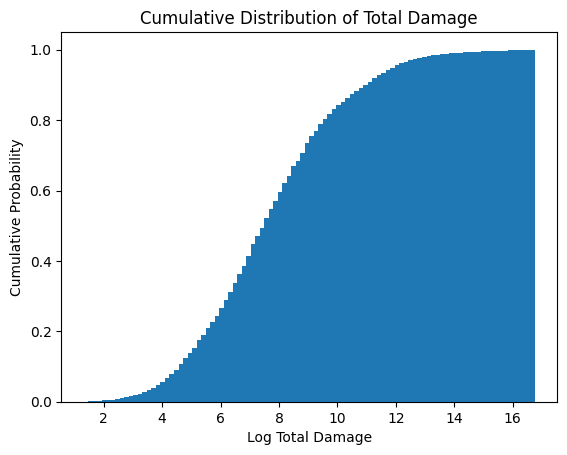

In [9]:
import matplotlib.pyplot as plt

plt.hist(data['log_total_damage'], bins=100, cumulative=True, density=True)
plt.xlabel('Log Total Damage')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Total Damage')
plt.show()

In [10]:
reg_temp = smf.ols('total_damage ~ temperature_change', data=data_dummy).fit()
reg_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_damage   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1258.
Date:                Wed, 11 Sep 2024   Prob (F-statistic):          8.26e-273
Time:                        10:58:27   Log-Likelihood:            -9.5846e+05
No. Observations:               64305   AIC:                         1.917e+06
Df Residuals:                   64303   BIC:                         1.917e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.727e+05   1.03e+04    -26.363      0.000   -2.93e+05   -2.52e+05
temperature_change  2.316e+05   6531.738     35.462      0.000    2.19e+05    2.44e+05
==============================================================================
Omnibus:                   131176.904   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        327909684.199
Skew:                          17.380   Prob(JB):                         0.00
Kurtosis:                     351.101   Cond. No.                         7.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's try by having a dummy by region.

In [11]:
# Regressing
reg_country = sm.OLS(data_dummy['log_total_damage'], sm.add_constant(data_dummy[['temperature_change', 'coef'] + dummy_regions])).fit()
reg_country.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_total_damage   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                 2.155e+04
Date:                Wed, 11 Sep 2024   Prob (F-statistic):               0.00
Time:                        10:58:27   Log-Likelihood:                -77891.
No. Observations:               64305   AIC:                         1.558e+05
Df Residuals:                   64280   BIC:                         1.561e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.6336      0.020    179.570      0.000       3.594       3.673
temperature_change     2.7102      0.007    366.909      0.000       2.696       2.725
coef                   0.8278      0.003    249.910      0.000       0.821       0.834
region_BULGARIA       -2.5736      0.023   -111.304      0.000      -2.619      -2.528
region_CHINA           3.6909      0.023    160.294      0.000       3.646       3.736
region_CROATIA        -2.3168      0.023   -100.560      0.000      -2.362      -2.272
region_CYPRUS         -3.4642      0.023   -150.395      0.000      -3.509      -3.419
region_DENMARK        -0.5091      0.023    -21.937      0.000      -0.555      -0.464
region_ESTONIA        -2.8305      0.023   -122.828      0.000      -2.876      -2.785
region_FINLAND        -0.7895      0.023    -34.168      0.000      -0.835      -0.744
region_FRANCE          1.6802      0.023     72.996      0.000       1.635       1.725
region_GERMANY         2.1671      0.024     91.976      0.000       2.121       2.213
region_GREECE         -1.3000      0.023    -56.422      0.000      -1.345      -1.255
region_HUNGARY        -1.6242      0.023    -70.541      0.000      -1.669      -1.579
region_INDIA          -0.4229      0.024    -17.362      0.000      -0.471      -0.375
region_IRELAND        -0.4358      0.023    -18.922      0.000      -0.481      -0.391
region_LATVIA         -2.6013      0.018   -142.220      0.000      -2.637      -2.565
region_LITHUANIA      -2.3614      0.023   -102.435      0.000      -2.407      -2.316
region_LUXEMBOURG     -2.2910      0.024    -97.273      0.000      -2.337      -2.245
region_POLAND          0.3950      0.023     17.143      0.000       0.350       0.440
region_PORTUGAL       -0.9227      0.023    -40.025      0.000      -0.968      -0.878
region_RUSSIA          1.4644      0.023     63.540      0.000       1.419       1.510
region_SLOVAKIA       -1.7576      0.023    -76.255      0.000      -1.803      -1.712
region_SPAIN           0.5542      0.023     24.044      0.000       0.509       0.599
region_SWEDEN          0.0481      0.023      2.082      0.037       0.003       0.093
==============================================================================
Omnibus:                    25378.634   Durbin-Watson:                   1.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           149353.617
Skew:                          -1.805   Prob(JB):                         0.00
Kurtosis:                       9.536   Cond. No.                         54.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's now try with both dummy variables for the region and for the equation. 

In [16]:
# Regressing
reg_double = sm.OLS(data_dummy['log_total_damage'], sm.add_constant(data_dummy[['temperature_change', 'coef'] + dummy_equations + dummy_regions])).fit()
reg_double.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_total_damage   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 2.199e+04
Date:                Wed, 11 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:00:28   Log-Likelihood:                -75008.
No. Observations:               64305   AIC:                         1.501e+05
Df Residuals:                   64278   BIC:                         1.503e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            3.5008      0.020    176.563      0.000       3.462       3.540
temperature_change                               2.7102      0.007    383.725      0.000       2.696       2.724
coef                                             0.8278      0.003    261.363      0.000       0.822       0.834
equation_dice_tot_eq_dice_total_impact          -0.0686      0.008     -9.137      0.000      -0.083      -0.054
equation_witness_tot_eq_witness_total_impact     0.4669      0.008     62.208      0.000       0.452       0.482
region_BULGARIA                                 -2.5736      0.022   -116.405      0.000      -2.617      -2.530
region_CHINA                                     3.6909      0.022    167.640      0.000       3.648       3.734
region_CROATIA                                  -2.3168      0.022   -105.169      0.000      -2.360      -2.274
region_CYPRUS                                   -3.4642      0.022   -157.288      0.000      -3.507      -3.421
region_DENMARK                                  -0.5091      0.022    -22.942      0.000      -0.553      -0.466
region_ESTONIA                                  -2.8305      0.022   -128.457      0.000      -2.874      -2.787
region_FINLAND                                  -0.7895      0.022    -35.734      0.000      -0.833      -0.746
region_FRANCE                                    1.6802      0.022     76.341      0.000       1.637       1.723
region_GERMANY                                   2.1671      0.023     96.192      0.000       2.123       2.211
region_GREECE                                   -1.3000      0.022    -59.008      0.000      -1.343      -1.257
region_HUNGARY                                  -1.6242      0.022    -73.774      0.000      -1.667      -1.581
region_INDIA                                    -0.4229      0.023    -18.158      0.000      -0.469      -0.377
region_IRELAND                                  -0.4358      0.022    -19.789      0.000      -0.479      -0.393
region_LATVIA                                   -2.6013      0.017   -148.738      0.000      -2.636      -2.567
region_LITHUANIA                                -2.3614      0.022   -107.129      0.000      -2.405      -2.318
region_LUXEMBOURG                               -2.2910      0.023   -101.731      0.000      -2.335      -2.247
region_POLAND                                    0.3950      0.022     17.929      0.000       0.352       0.438
region_PORTUGAL                                 -0.9227      0.022    -41.859      0.000      -0.966      -0.879
region_RUSSIA                                    1.4644      0.022     66.452      0.000       1.421       1.508
region_SLOVAKIA                 

In [13]:
residuals.plot()

NameError: name 'residuals' is not defined

In [145]:
data

,time,region,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,coef,Run,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,...,log_temperature_change,log_coef,log_total_damage,pop_est_x,index_x,pop_est_y,REGIONS 35 I_x,index_y,pop_est,REGIONS 35 I_y
0,2005.0,BELGIUM,-2.120837,14345.919289,1.714491,0.484972,0,0.845000,4.580816e+05,24767.399895,...,-0.168419,-0.723664,6.120868,NaN,Belgium,1.148406e+07,BELGIUM,Belgium,1.148406e+07,BELGIUM
1,2005.0,BULGARIA,-2.120837,14345.919289,1.714491,3.328578,0,0.845000,4.934207e+04,4290.060541,...,-0.168419,1.202545,5.818807,NaN,Bulgaria,6.975761e+06,BULGARIA,Bulgaria,6.975761e+06,BULGARIA
2,2005.0,CROATIA,-2.120837,14345.919289,1.714491,1.784685,0,0.845000,4.937873e+04,7565.730576,...,-0.168419,0.579242,5.196246,NaN,Croatia,4.067500e+06,CROATIA,Croatia,4.067500e+06,CROATIA
3,2005.0,CYPRUS,-2.120837,14345.919289,1.714491,0.828186,0,0.845000,2.025158e+04,15217.411656,...,-0.168419,-0.188518,3.537200,NaN,Cyprus,1.198575e+06,CYPRUS,Cyprus,1.198575e+06,CYPRUS
4,2005.0,DENMARK,-2.120837,14345.919289,1.714491,0.413845,0,0.845000,2.966163e+05,28613.689785,...,-0.168419,-0.882264,5.527660,NaN,Denmark,5.818553e+06,DENMARK,Denmark,5.818553e+06,DENMARK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64300,2060.0,SPAIN,-2.424749,21416.325501,4.301696,1.039594,14,2.301589,4.390592e+06,60262.874768,...,0.833600,0.038830,11.905236,NaN,Spain,4.707678e+07,SPAIN,Spain,4.707678e+07,SPAIN
64301,2060.0,SWEDEN,-2.424749,21416.325501,4.301696,1.120749,14,2.301589,3.322320e+06,163450.170364,...,0.833600,0.113997,11.701603,NaN,Sweden,1.028545e+07,SWEDEN,Sweden,1.028545e+07,SWEDEN
64302,2060.0,CHINA,-2.424749,21416.325501,4.301696,1.120143,14,2.301589,2.935497e+08,162281.171834,...,0.833600,0.113456,16.182446,NaN,China,1.397715e+09,CHINA,China,1.397715e+09,CHINA
64303,2060.0,INDIA,-2.424749,21416.325501,4.301696,0.746499,14,2.301589,4.027580e+06,742.585934,...,0.833600,-0.292361,11.487747,NaN,India,1.366418e+09,INDIA,India,1.366418e+09,INDIA


We check the residuals distribution : they are clearly correlated with the region. 

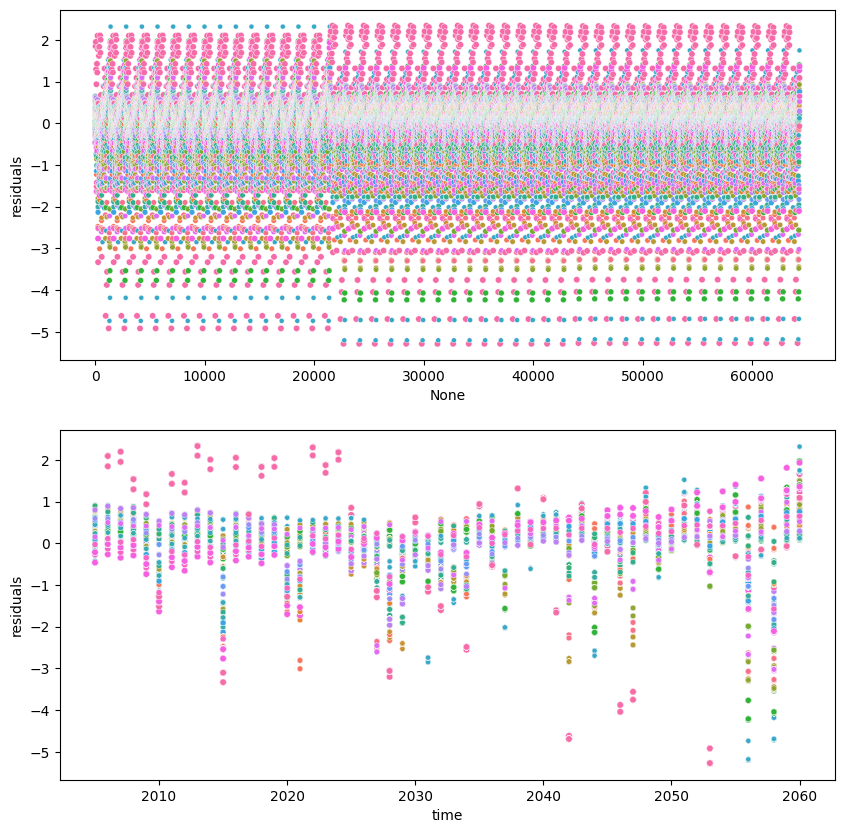

In [173]:
residuals = reg_double.resid

#joint = residuals.join(data_dummy[['temperature_change', 'coef'] + dummy_equations + dummy_regions])
data['residuals'] = residuals

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

sns.scatterplot(data=data, x=data.index, y='residuals', hue='region', s=np.log(data['pop_est']), legend=False, ax=axs[0])
sns.scatterplot(data=data, x='time', y='residuals', hue='region', s=np.log(data['pop_est']), legend=False, ax=axs[1])

#residuals.plot(ax=ax, color='black', alpha=0.5)

plt.show()


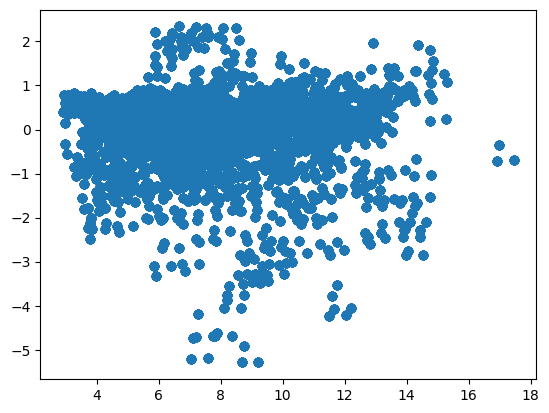

In [18]:
plt.scatter(reg_double.fittedvalues, reg_double.resid)

In [27]:
df_residuals = pd.DataFrame({'Fitted Values': reg_double.fittedvalues, 'Residuals': reg_double.resid})
df_residuals

,Fitted Values,Residuals
0,6.192382,-0.071514
1,5.972808,-0.154001
2,4.951509,0.244738
3,3.012334,0.524866
4,5.624406,-0.096746
...,...,...
64300,11.620229,0.285007
64301,11.181327,0.520276
64302,14.823633,1.358813
64303,10.400525,1.087222


c:\Users\gabriel.genelot\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


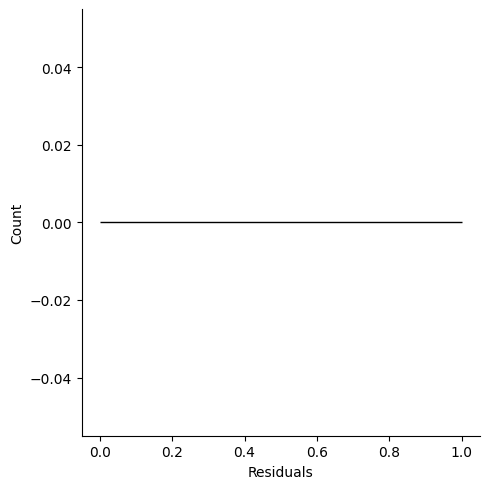

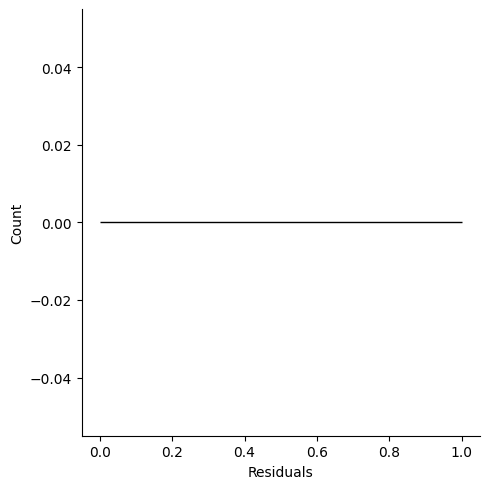

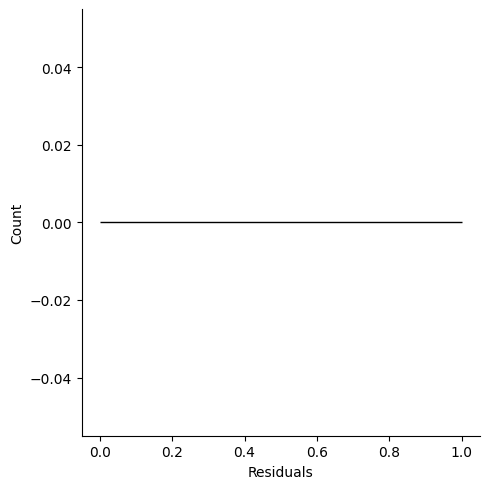

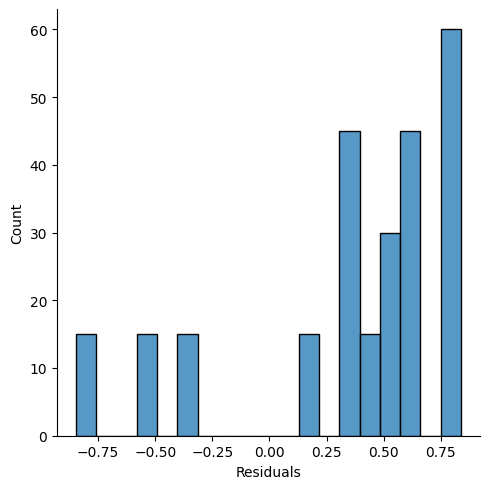

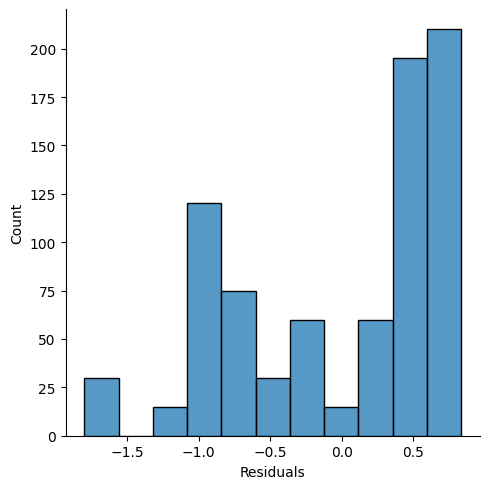

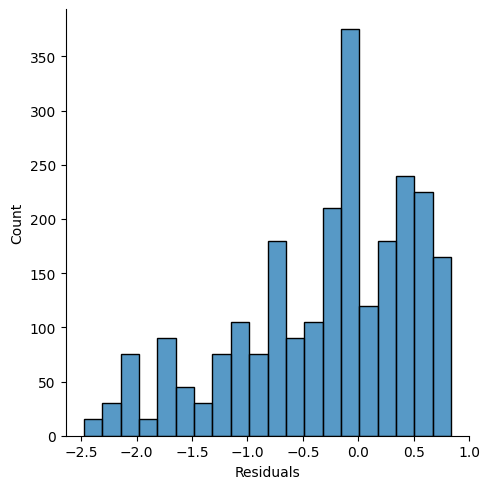

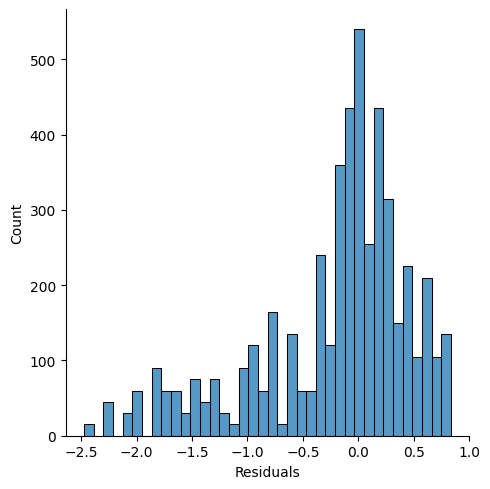

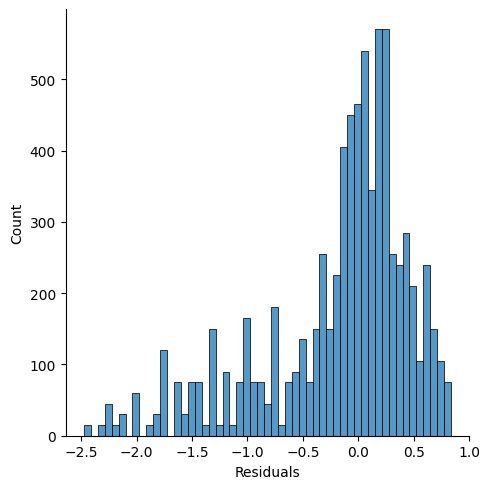

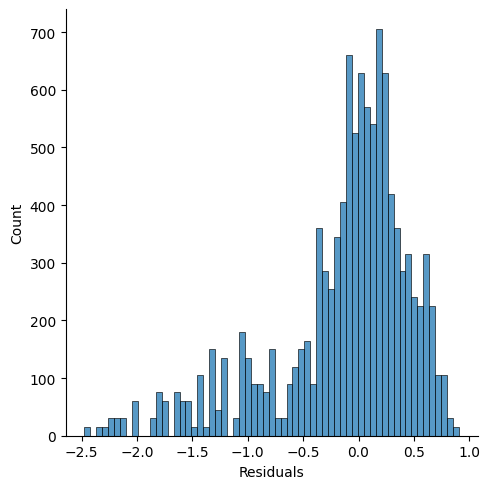

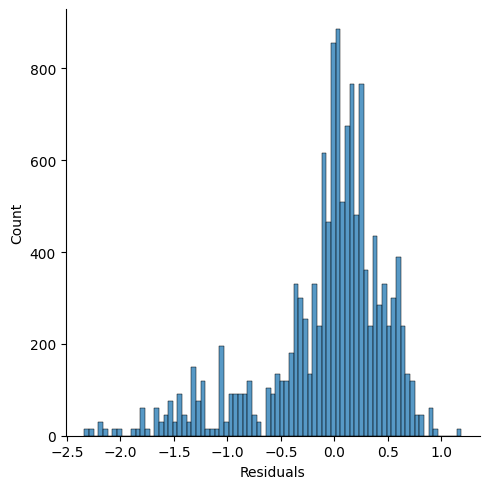

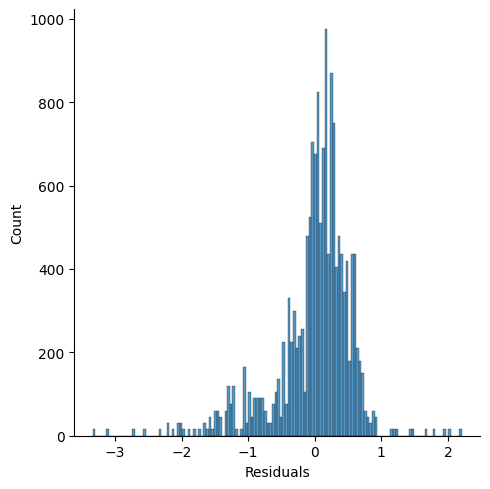

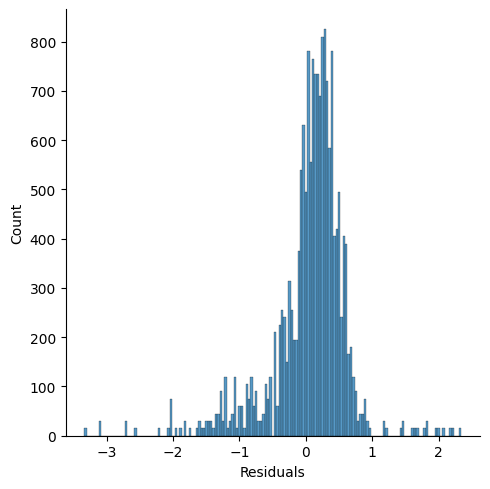

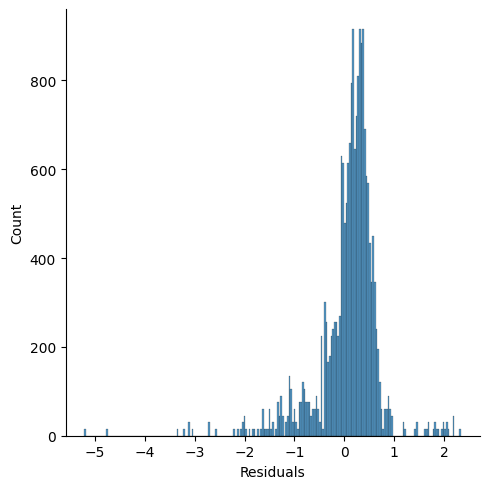

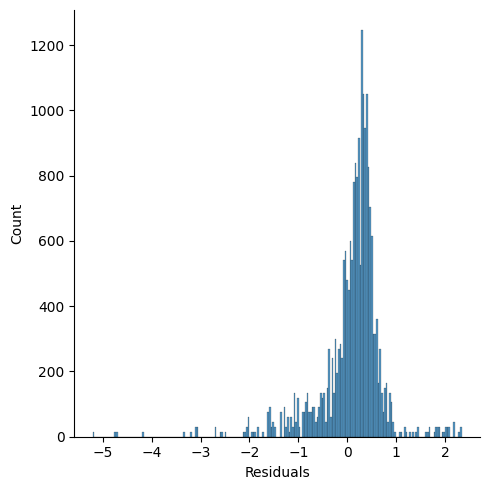

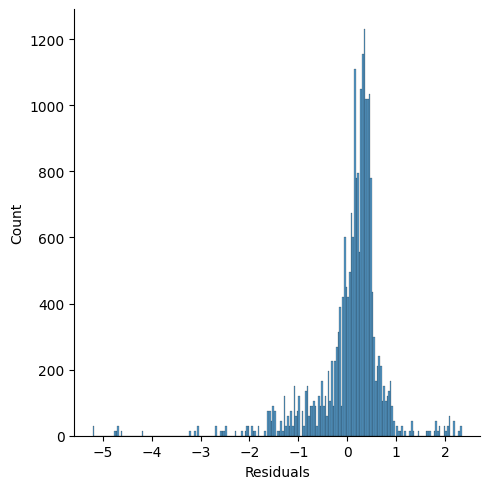

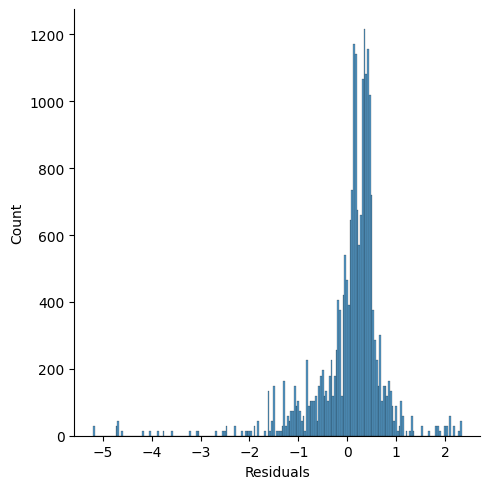

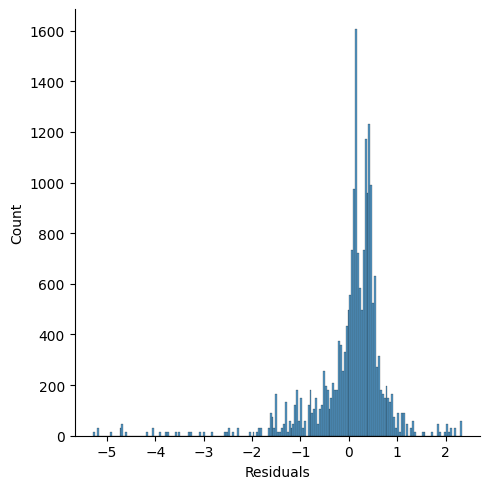

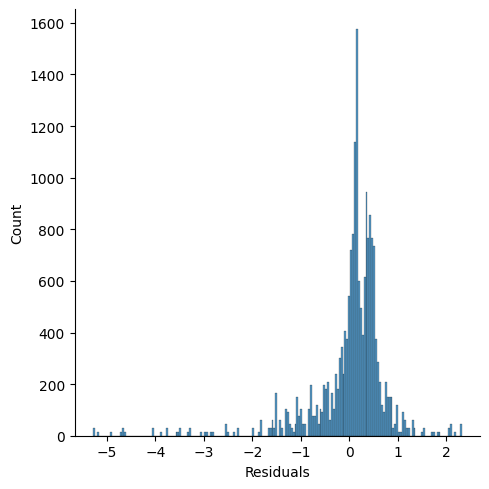

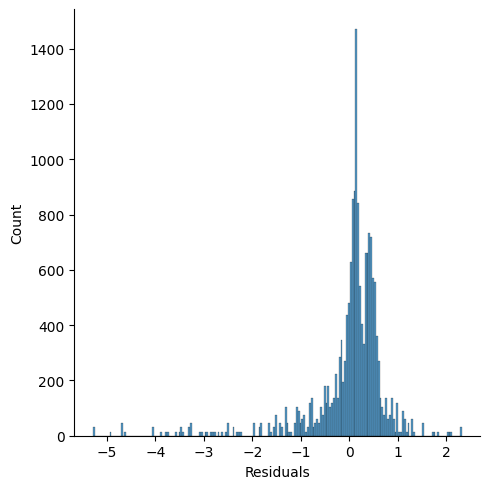

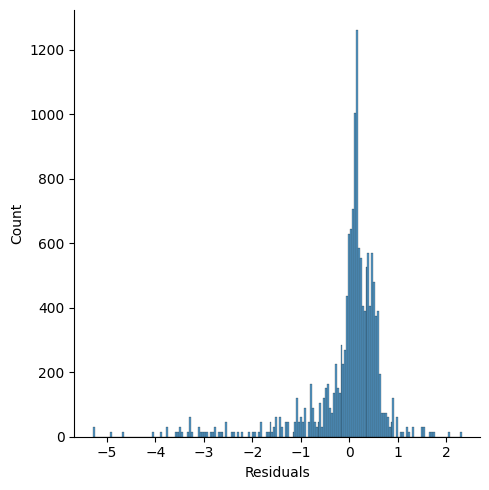

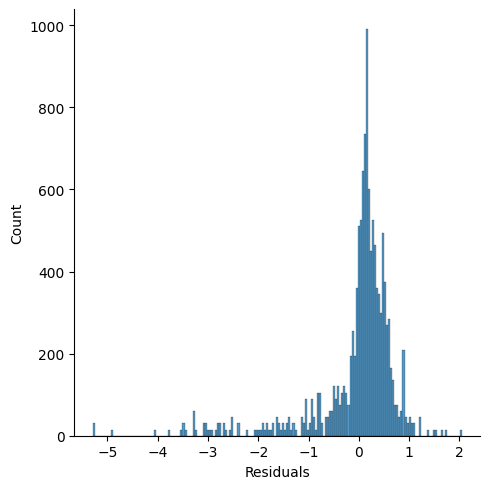

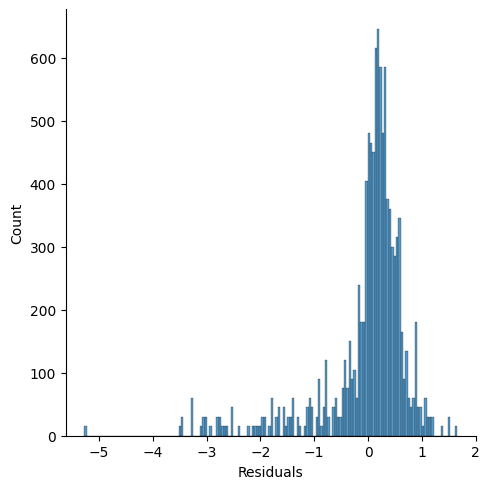

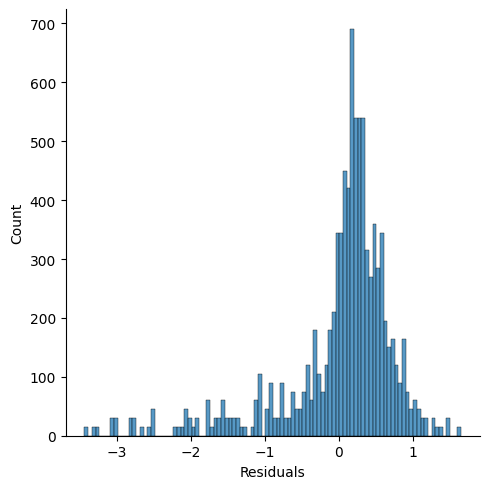

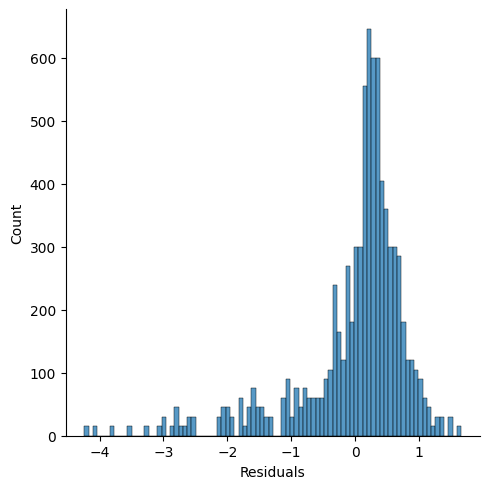

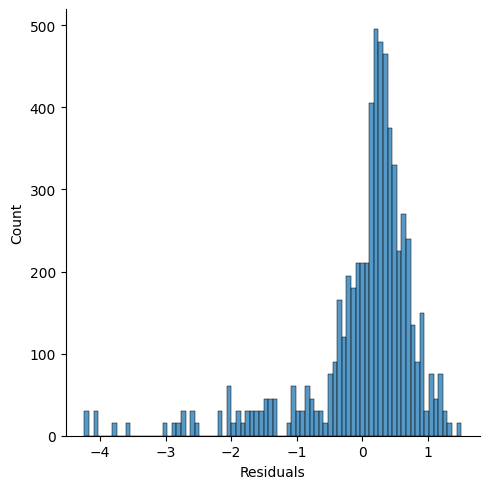

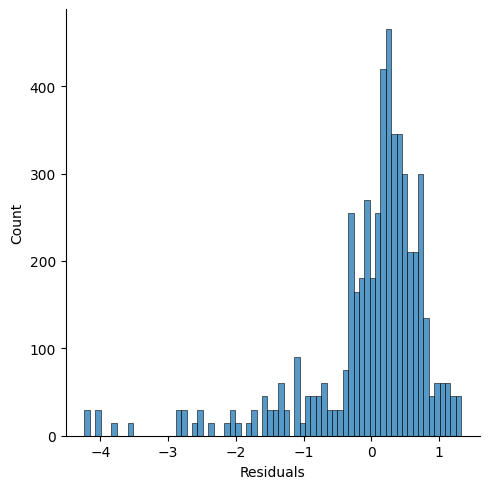

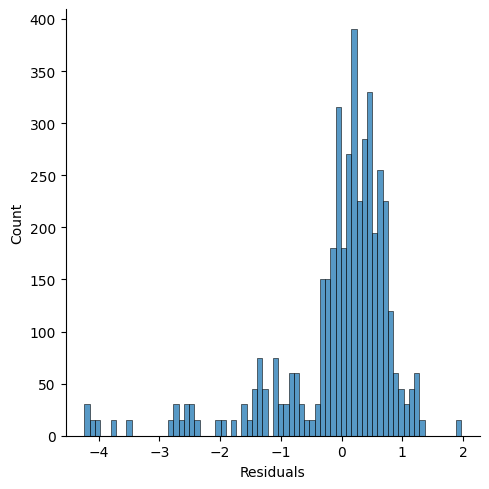

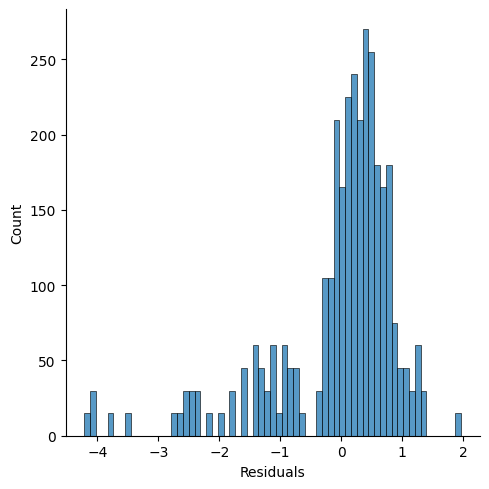

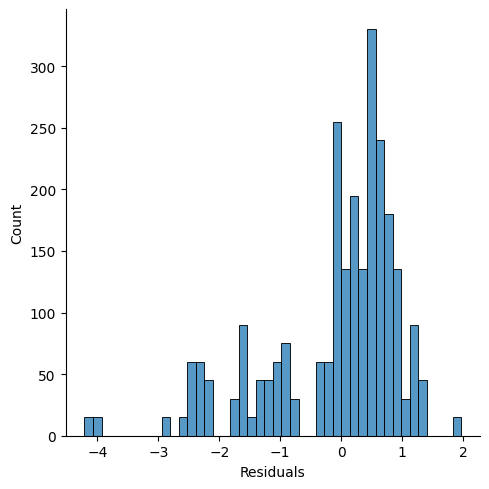

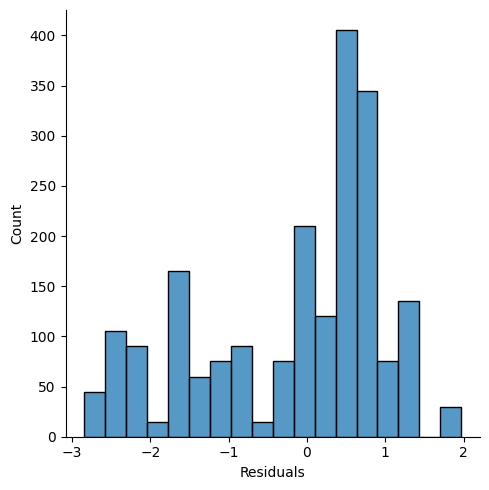

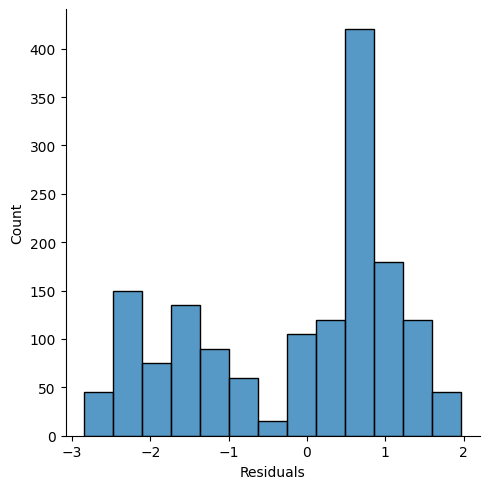

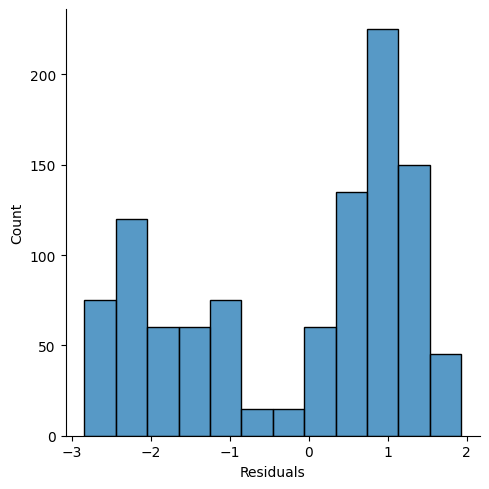

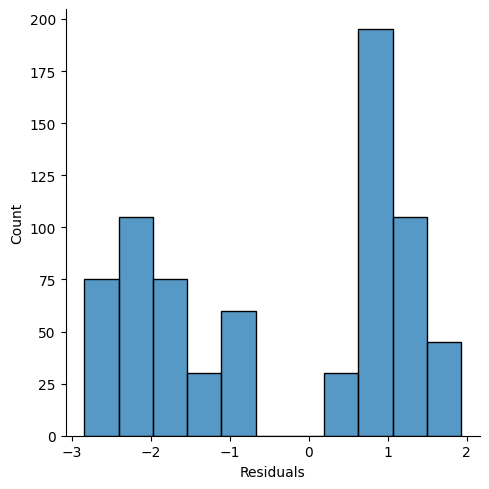

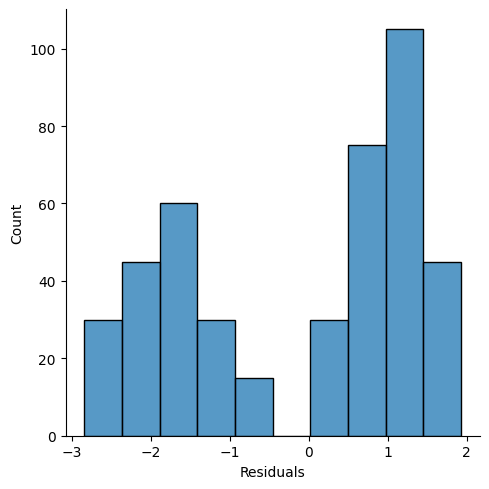

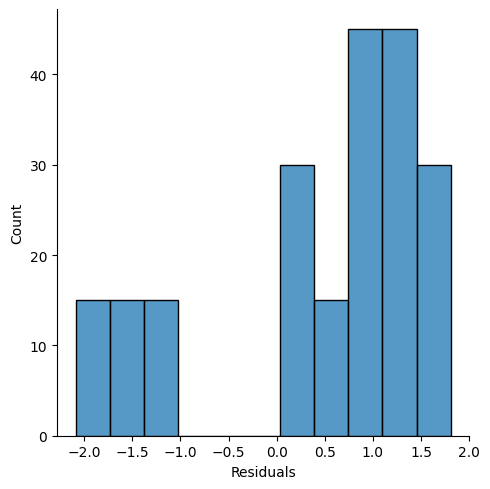

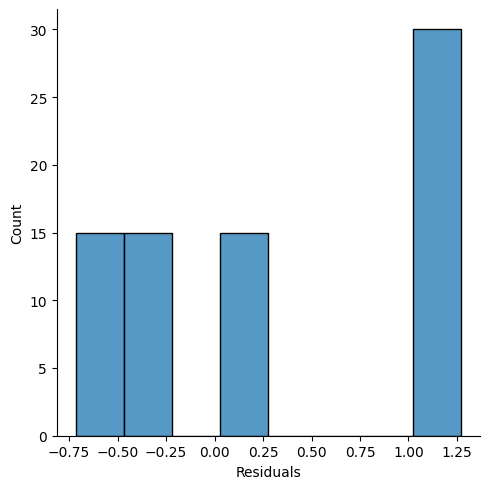

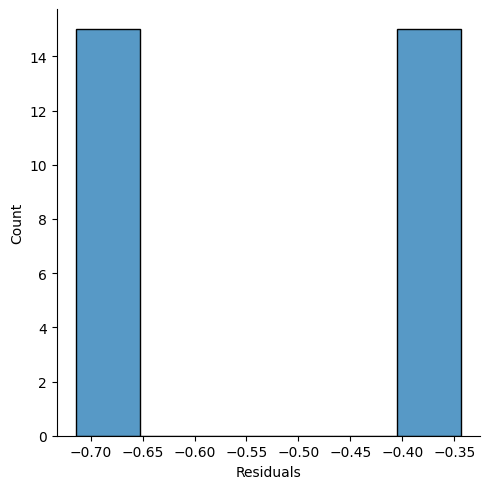

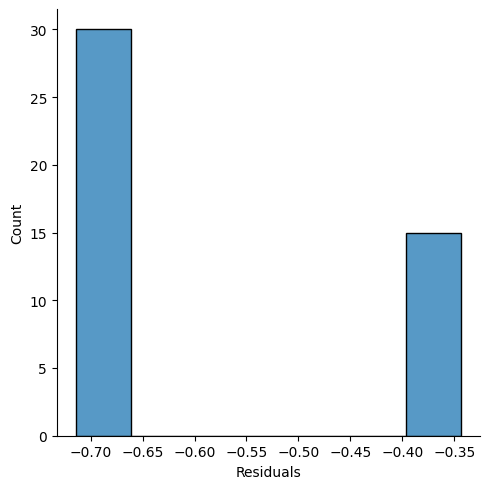

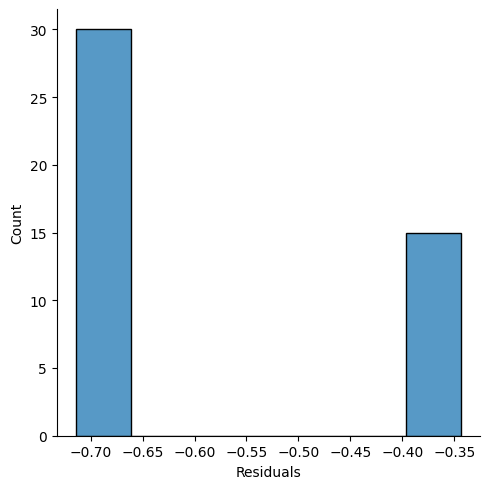

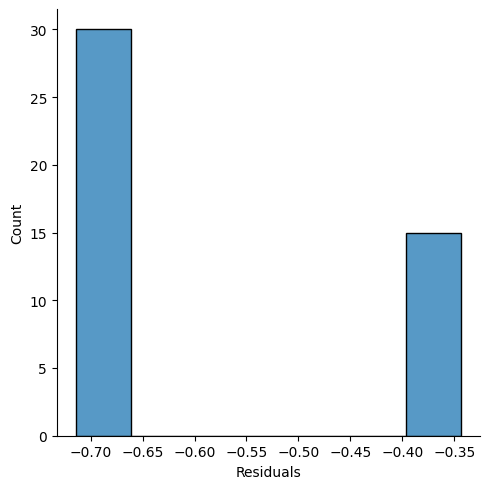

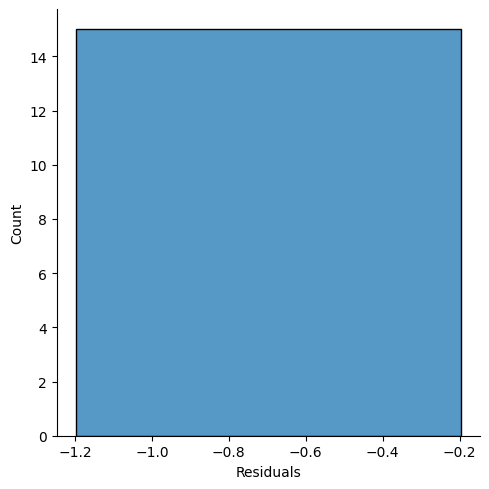

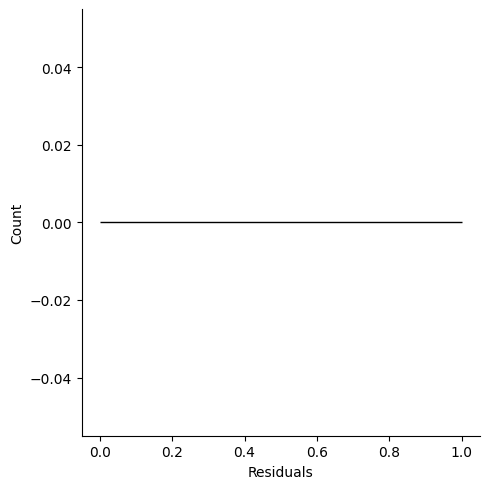

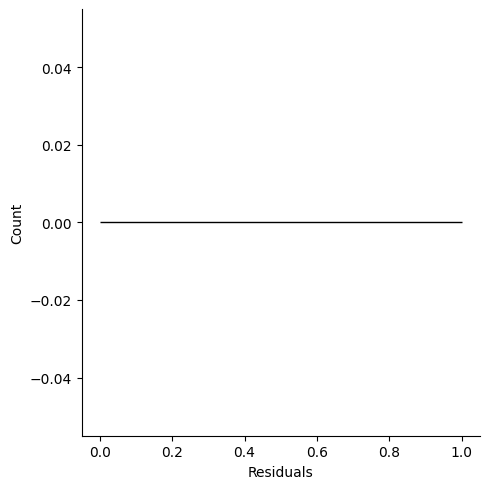

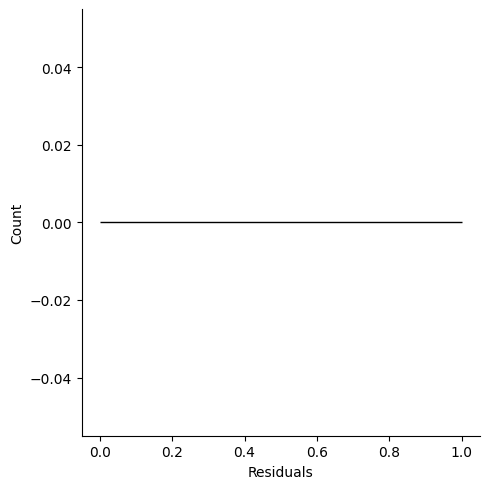

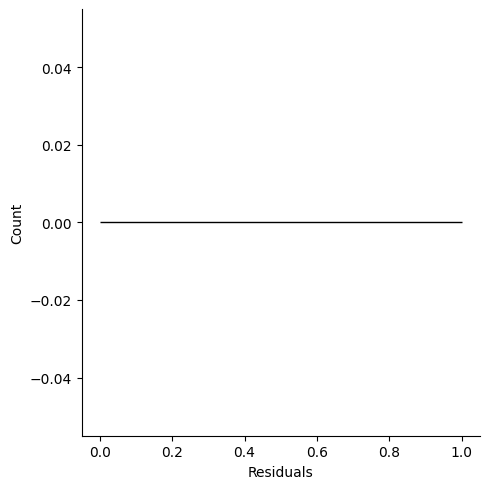

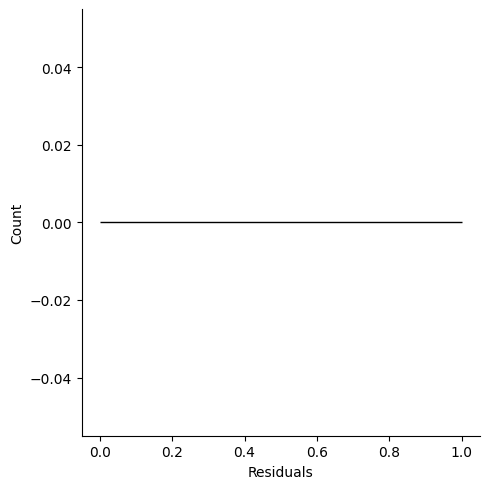

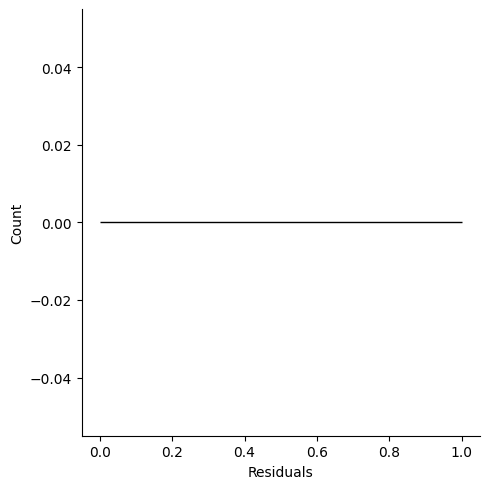

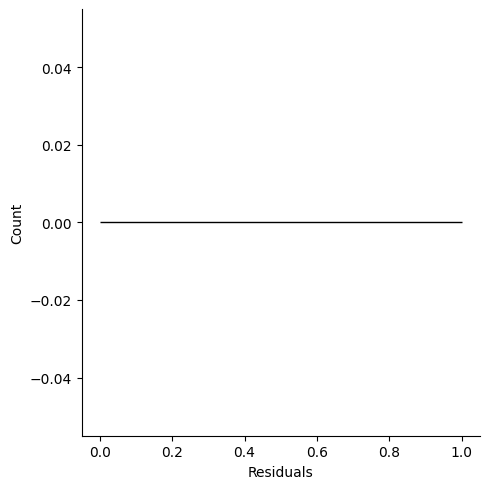

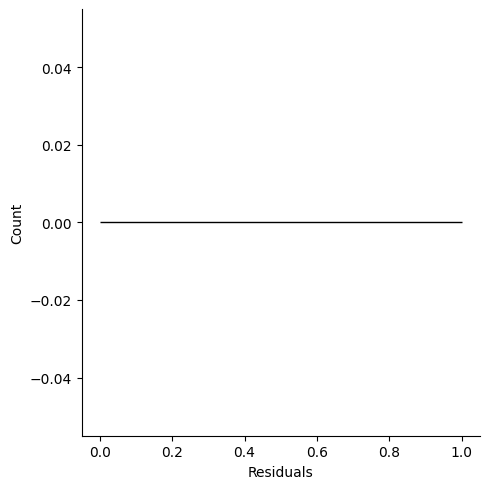

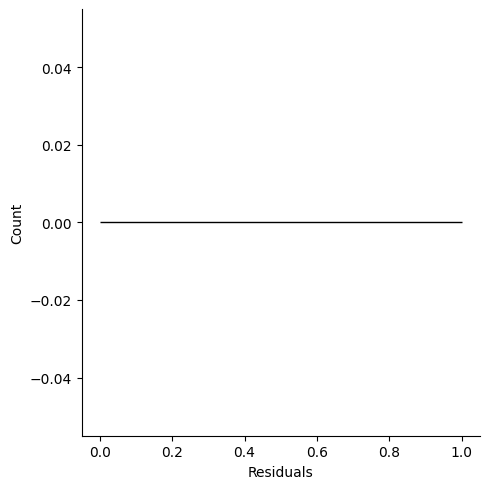

In [29]:
df_residuals = pd.DataFrame({'Fitted Values': reg_double.fittedvalues, 'Residuals': reg_double.resid})


for x in np.linspace(0, 21) : 
    subset = df_residuals[(df_residuals['Fitted Values'] > x) & (df_residuals['Fitted Values'] < x + 2)]
    sns.displot(data=subset, x='Residuals')

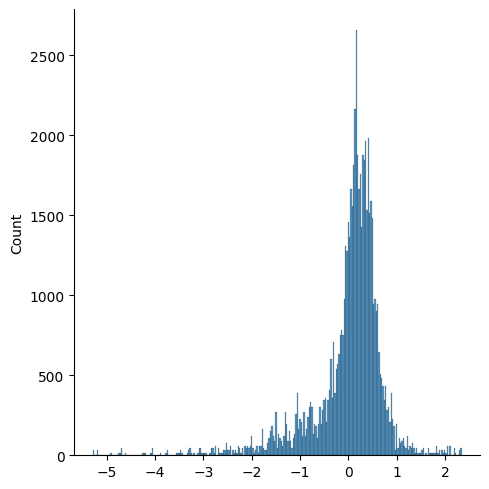

In [24]:
sns.displot(reg_double.resid)

To the table.

In [147]:
# Creating the stargazer object
stargazer = Stargazer([reg_temp, reg_simple, reg_equation, reg_country, reg_double])

# Customizing the table
#stargazer.title('Résultats de la régression')
stargazer.show_model_numbers(True)
stargazer.cov_spacing = 2

# Showing everthing except countries
variables_to_show = ['temperature_change', 'coef'] + dummy_equations
stargazer.covariate_order(variables_to_show)

# Customizing the columns and lines titles
stargazer.custom_columns(['Temp', 'Simple', 'Equation', 'Country', 'Double'], [1, 1, 1, 1, 1])
stargazer.rename_covariates({'temperature_change': 'Temperature Change',
                              'coef': 'Ethical coefficient', 
                              'equation': 'Model',
                              'region': 'Region', 
                              'equation_dice_tot_eq_dice_total_impact': 'DICE form damage function',
                              'equation_witness_tot_eq_witness_total_impact': 'WITNESS form damage function',})


stargazer.add_line('Regional dummy', ['No', 'No', 'No', 'Yes', 'Yes'])



stargazer.add_custom_notes(['This is a note'])

# Rendering to latex to include in the report
latex_code=stargazer.render_latex()
latex_code = latex_code.replace('_', r'\_')

# Saving it to the report folder
with open('../../../../Memoire/results/reg.tex', 'w') as f:
    f.write(latex_code)

# Showing the table
stargazer


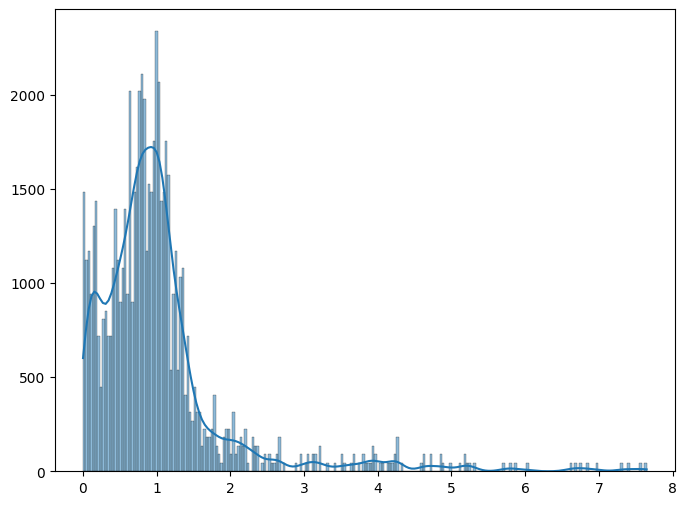

In [148]:
import matplotlib.pyplot as plt

# Créer une figure
fig, ax = plt.subplots(figsize=(8, 6))


sns.histplot(data=data, x='coef', kde=True, ax=ax)

# Remove the x-label and y-label
ax.set_xlabel('')
ax.set_ylabel('')

# Enregistrer la figure
fig.savefig('../../../../Memoire/results/coef.png', dpi=300)

### Explaining each region x time value by the choice of the model, temperature and the choice of the coefficient

Here, we test a very straight-forward model that explains the level of damage by a few straight-forward variables : 

$$

\text{Damage}_{t,r} = \beta_0 + \beta_1 \cdot GDP_{t,r} + \beta_2 \cdot \text{Temperature change} + \beta_3 \cdot coef_{t,r}
 
$$

By trials and mistake, we have come to the conclusion that using log_total_damage was a better use. In fact, it appears that this is just re-writting the same equation differently. 

$$

\begin{align*}
& D_{t,r} = f(\text{temperature}, \text{other drivers})_{t,r} \cdot GDP_{t,r} \cdot (\frac{y_{t,r}}{y_0})^\alpha \\
\iff  & D_{t,r} = \text{temperature}_{t,r}^{\beta_1} \cdot GDP_{t,r}^{\beta_2} \cdot \text{coef}^{\beta_3} \\
\iff & log(D_{t,r}) = log(\text{temperature}_{t,r}^{\beta_1} \cdot GDP_{t,r}^{\beta_2} \cdot \text{coef}^{\beta_3}) \\
\iff & log(D_{t,r}) = \beta_1 \cdot log(\text{temperature}_{t,r}) + \beta_2 \cdot log(GDP_{t,r}) + \beta_3 \cdot log(\text{coef})
\end{align*}

$$


In [149]:
regression_simple = sm.OLS(data['log_total_damage'], sm.add_constant(data[['log_temperature_change', 'log_coef', 'log_gross_domestic_product_nominal']])).fit()
regression_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_total_damage   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 1.756e+06
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:56:52   Log-Likelihood:                -6647.3
No. Observations:               64305   AIC:                         1.330e+04
Df Residuals:                   64301   BIC:                         1.334e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -5.5955      0.007   -786.494      0.000      -5.609      -5.582
log_temperature_change                 2.2726      0.004    607.149      0.000       2.265       2.280
log_coef                               0.9981      0.001   1066.450      0.000       0.996       1.000
log_gross_domestic_product_nominal     1.0022      0.001   1746.742      0.000       1.001       1.003
==============================================================================
Omnibus:                   371126.580   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7697.300
Skew:                           0.377   Prob(JB):                         0.00
Kurtosis:                       1.482   Cond. No.                         87.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We find a R-squared coefficient of 0.990, which means that the variables we take into account explain 99% of the variability of the level of climate damage. This is consistent with the way the climate damages have been designed : they are precisely a combination of temperature, GDP and the coef. We have linearized the function, which was a product, by passing it through the log function. 

In [150]:
data['total_damage'].corr(data['coef'])

0.12721717681536276

<Axes: xlabel='log_gross_domestic_product_nominal', ylabel='log_total_damage'>

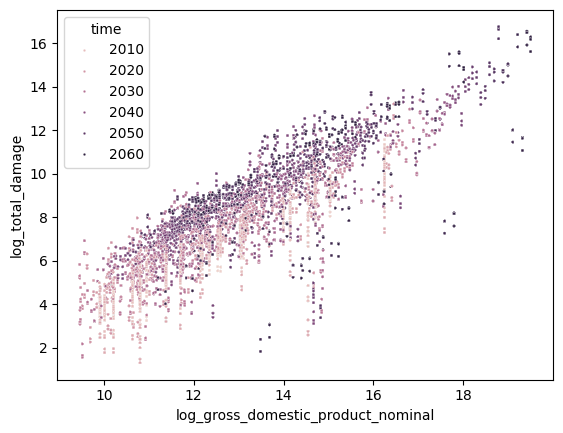

In [151]:
sns.scatterplot(data=data, x='log_gross_domestic_product_nominal', y='log_total_damage', hue='time', s=3)

### As aggregated data by country

Now, the thing we are being interested in is the global level of damage. Indeed, that is the metric used by SCC specialists to compute the optimal level of carbon emissions and the associated Social Cost of Carbon. 

We'll use the same dataset and sum the damages by year for every region, in order to have a global level of damage for every year. These levels of damage will be differentiated by their coef, the temperature change associated with it. 

We will then compute the following model : 

$$

\text{Global damage} = \beta_0 + \beta_1 \cdot \text{temperature change} + \beta_2 \cdot \text{coef}

$$

In [152]:
data_global = data.groupby(['time', 'equation', 'coef', 'temperature_change']).agg({'total_damage':'sum', 'gross_domestic_product_nominal': 'sum'}).reset_index()
data_global = pd.get_dummies(data_global, columns=['equation'])
data_global["decade"] = (data_global["time"] // 10 *10)

data_global

,time,coef,temperature_change,total_damage,gross_domestic_product_nominal,equation_define_tot_eq_define_total_impact,equation_dice_tot_eq_dice_total_impact,equation_witness_tot_eq_witness_total_impact,decade
0,2005.0,0.221798,0.845000,3.893736e+02,8.566627e+05,True,False,False,2000.0
1,2005.0,0.413845,0.845000,3.773318e+03,4.449244e+06,True,False,False,2000.0
2,2005.0,0.443601,0.845000,6.766947e+03,7.443897e+06,True,False,False,2000.0
3,2005.0,0.447308,0.845000,3.826781e+03,4.174716e+06,True,False,False,2000.0
4,2005.0,0.452608,0.845000,4.712938e+04,5.081238e+07,True,False,False,2000.0
...,...,...,...,...,...,...,...,...,...
3778,2060.0,1.157055,2.301589,2.697718e+06,7.188705e+07,False,False,True,2060.0
3779,2060.0,1.159320,2.301589,1.426049e+06,3.792619e+07,False,False,True,2060.0
3780,2060.0,1.170112,2.301589,1.224897e+06,3.227606e+07,False,False,True,2060.0
3781,2060.0,1.225088,2.301589,3.956468e+07,9.957464e+08,False,False,True,2060.0


In [153]:

data_global["decade"] = (data_global["time"] // 10 *10)

y =  np.log(data_global['total_damage'])
X = data_global[['coef' , 'equation_define_tot_eq_define_total_impact',  'equation_witness_tot_eq_witness_total_impact']]

X = X.astype(float)



regression_global = sm.OLS(y, sm.add_constant(X)).fit() 
regression_global.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_damage   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     224.5
Date:                Tue, 10 Sep 2024   Prob (F-statistic):          4.88e-134
Time:                        17:56:54   Log-Likelihood:                -8376.9
No. Observations:                3783   AIC:                         1.676e+04
Df Residuals:                    3779   BIC:                         1.679e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            9.5513      0.073    131.316      0.000       9.409       9.694
coef                                             0.8897      0.035     25.099      0.000       0.820       0.959
equation_define_tot_eq_define_total_impact       0.0682      0.088      0.773      0.440      -0.105       0.241
equation_witness_tot_eq_witness_total_impact     0.5355      0.088      6.066      0.000       0.362       0.709
==============================================================================
Omnibus:                       94.739   Durbin-Watson:                   1.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.626
Skew:                           0.388   Prob(JB):                     8.55e-23
Kurtosis:                       3.209   Cond. No.                         5.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Same taking into account the time : higher R squared, but strong collinearity. 

In [154]:
y =  np.log(data_global['total_damage'])
X = data_global[['time', 'coef' , 'equation_define_tot_eq_define_total_impact',  'equation_witness_tot_eq_witness_total_impact']]

X = X.astype(float)



regression_global = sm.OLS(y, sm.add_constant(X)).fit() 
regression_global.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_damage   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     560.5
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:56:54   Log-Likelihood:                -7806.0
No. Observations:                3783   AIC:                         1.562e+04
Df Residuals:                    3778   BIC:                         1.565e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                         -132.6895      3.899    -34.032      0.000    -140.334    -125.045
time                                             0.0700      0.002     36.486      0.000       0.066       0.074
coef                                             0.8424      0.031     27.607      0.000       0.783       0.902
equation_define_tot_eq_define_total_impact       0.0682      0.076      0.899      0.369      -0.081       0.217
equation_witness_tot_eq_witness_total_impact     0.5355      0.076      7.053      0.000       0.387       0.684
==============================================================================
Omnibus:                       75.261   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.374
Skew:                           0.346   Prob(JB):                     5.81e-18
Kurtosis:                       3.154   Cond. No.                     2.56e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: xlabel='coef', ylabel='total_damage'>

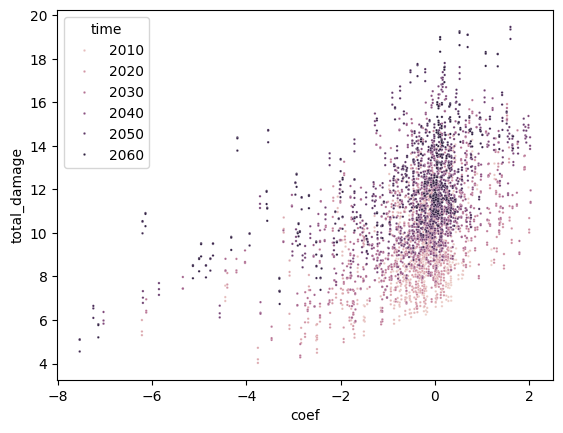

In [155]:
sns.scatterplot(data=data_global, x=np.log(data_global['coef']), y=np.log(data_global['total_damage']), s=3, hue='time')

<Axes: xlabel='time', ylabel='total_damage'>

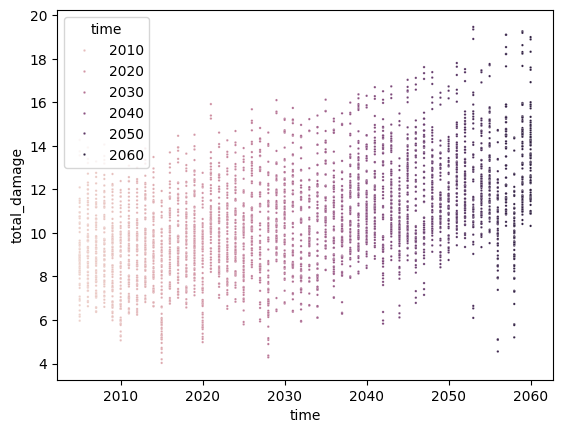

In [156]:
sns.scatterplot(data= data_global, x='time',  y=np.log(data_global['total_damage']), s=3, hue='time')

### Without the equation dummies

In [157]:
# Group by time, region, and equation, and sum the total damage (aggregated data)
df_regression = df_melted.groupby(['time', 'extra_extra_exponent', 'extra_extra_normalisation_constant', 'total_radiative_forcing', 'equation']).sum().reset_index()

# Create a dummy for each damage function
#df_regression = pd.get_dummies(df_regression, columns=['equation'], drop_first=False)

# Drop the null values
df_regression.replace([np.inf, -np.inf], np.nan, inplace=True)
df_regression = df_regression.dropna()

# Define the dependant variable and the independant variables
y = df_regression['total_damage']
X = df_regression.drop(columns=['total_damage', 'REGIONS 35 I', 'equation', 'coef'], axis=1)

# Add a constant to the independant variables
X = sm.add_constant(X)

# Convert the data to float
X = X.astype(float)
y = y.astype(float)

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_damage   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     1172.
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:56:55   Log-Likelihood:                -41233.
No. Observations:                2520   AIC:                         8.248e+04
Df Residuals:                    2511   BIC:                         8.254e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                -6.595e+08    2.6e+08     -2.540      0.011   -1.17e+09    -1.5e+08
time                                  3.373e+05   1.32e+05      2.558      0.011    7.87e+04    5.96e+05
extra_extra_exponent                 -1.471e+05   6.08e+04     -2.421      0.016   -2.66e+05    -2.8e+04
extra_extra_normalisation_constant     -12.0493      5.421     -2.223      0.026     -22.679      -1.420
total_radiative_forcing              -1.218e+07   2.84e+06     -4.296      0.000   -1.77e+07   -6.62e+06
Run                                   -320.2881    446.436     -0.717      0.473   -1195.708     555.131
temperature_change                    8.044e+04   1.31e+04      6.159      0.000    5.48e+04    1.06e+05
gross_domestic_product_nominal           0.1419      0.003     55.278      0.000       0.137       0.147
average_disposable_income_per_capita   -15.4955      0.348    -44.536      0.000     -16.178     -14.813
==============================================================================
Omnibus:                      533.953   Durbin-Watson:                   1.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5897.620
Skew:                           0.675   Prob(JB):                         0.00
Kurtosis:                      10.372   Cond. No.                     1.06e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

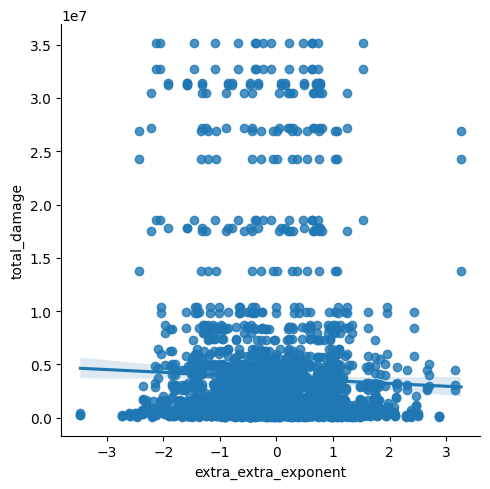

In [158]:
sns.lmplot(data=df_regression, x='extra_extra_exponent', y='total_damage')

### Without countries as dummy

In [159]:
# Group by time, region, and equation, and sum the total damage (aggregated data)
df_regression = df_melted.groupby(['time', 'extra_extra_exponent', 'extra_extra_normalisation_constant', 'total_radiative_forcing', 'equation']).sum().reset_index()

# Create a dummy for each damage function
df_regression = pd.get_dummies(df_regression, columns=['equation'], drop_first=True)

# Drop the null values
df_regression.replace([np.inf, -np.inf], np.nan, inplace=True)
df_regression = df_regression.dropna()

# Define the dependant variable and the independant variables
y = df_regression['total_damage']
X = df_regression.drop(columns=['total_damage', 'REGIONS 35 I', 'time', 'extra_extra_normalisation_constant', 'extra_extra_exponent', 'gross_domestic_product_nominal', 'average_disposable_income_per_capita', 'Run', 'temperature_change'], axis=1)

# Add a constant to the independant variables
X = sm.add_constant(X)

# Convert the data to float
X = X.astype(float)
y = y.astype(float)

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_damage   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     501.0
Date:                Tue, 10 Sep 2024   Prob (F-statistic):          5.34e-318
Time:                        17:56:55   Log-Likelihood:                -42454.
No. Observations:                2520   AIC:                         8.492e+04
Df Residuals:                    2515   BIC:                         8.495e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                        -1.489e+07   4.67e+05    -31.906      0.000   -1.58e+07    -1.4e+07
total_radiative_forcing                       5.346e+06   1.31e+05     40.711      0.000    5.09e+06     5.6e+06
coef                                          9.898e+04   7328.425     13.507      0.000    8.46e+04    1.13e+05
equation_dice_tot_eq_dice_total_impact       -1.342e+06   2.45e+05     -5.479      0.000   -1.82e+06   -8.62e+05
equation_witness_tot_eq_witness_total_impact  6.083e+05   2.45e+05      2.484      0.013    1.28e+05    1.09e+06
==============================================================================
Omnibus:                     1302.833   Durbin-Watson:                   0.355
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7894.563
Skew:                           2.452   Prob(JB):                         0.00
Kurtosis:                      10.151   Cond. No.                         162.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [160]:
# Creating the stargazer object
stargazer = Stargazer([results])

# Customizing the table
stargazer.title('Résultats de la régression')
stargazer.show_model_numbers(False)

latex_code=stargazer.render_latex()

latex_code = latex_code.replace('_', r'\_')


with open('../../../../Memoire/results/reg.tex', 'w') as f:
    f.write(latex_code)


In [161]:
df_regression

,time,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,REGIONS 35 I,coef,Run,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,total_damage,equation_dice_tot_eq_dice_total_impact,equation_witness_tot_eq_witness_total_impact
0,2005.0,-2.499737,37291.354076,1.714491,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,35.992621,364,23.660000,6.946382e+07,4.609016e+05,2.210159e+05,False,False
1,2005.0,-2.499737,37291.354076,1.714491,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,35.992621,364,23.660000,6.946382e+07,4.609016e+05,2.669876e+05,True,False
2,2005.0,-2.499737,37291.354076,1.714491,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,35.992621,364,23.660000,6.946382e+07,4.609016e+05,4.511240e+05,False,True
3,2005.0,-2.483093,48301.730067,1.714491,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,35.992621,224,23.660000,6.946382e+07,4.609016e+05,2.210159e+05,False,False
4,2005.0,-2.483093,48301.730067,1.714491,BELGIUMBULGARIACROATIACYPRUSCZECH REPUBLICDENM...,35.992621,224,23.660000,6.946382e+07,4.609016e+05,2.669876e+05,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2060.0,1.071663,33617.864179,4.301696,AUSTRIABELGIUMBULGARIACROATIACYPRUSCZECH REPUB...,30.702805,35,80.555617,7.187911e+08,4.298371e+06,1.373452e+07,True,False
2516,2060.0,1.071663,33617.864179,4.301696,AUSTRIABELGIUMBULGARIACROATIACYPRUSCZECH REPUB...,30.702805,35,80.555617,7.187911e+08,4.298371e+06,2.425469e+07,False,True
2517,2060.0,3.259974,18841.706602,4.301696,AUSTRIABELGIUMBULGARIACROATIACYPRUSCZECH REPUB...,30.702805,385,80.555617,7.187911e+08,4.298371e+06,2.691910e+07,False,False
2518,2060.0,3.259974,18841.706602,4.301696,AUSTRIABELGIUMBULGARIACROATIACYPRUSCZECH REPUB...,30.702805,385,80.555617,7.187911e+08,4.298371e+06,1.373452e+07,True,False


### With countries as dummy

In [162]:
# Group by time, region, and equation, and sum the total damage (aggregated data)
df_regression = df_melted.groupby(['time', 'REGIONS 35 I', 'extra_extra_exponent', 'extra_extra_normalisation_constant', 'total_radiative_forcing', 'equation']).sum().reset_index()

# Create a dummy for each damage function
df_regression = pd.get_dummies(df_regression, columns=['equation', 'REGIONS 35 I'], drop_first=True)

# Drop the null values
df_regression.replace([np.inf, -np.inf], np.nan, inplace=True)
df_regression = df_regression.dropna()

# Define the dependant variable and the independant variables
y = df_regression['total_damage']
X = df_regression.drop(columns=['total_damage'], axis=1)

# Add a constant to the independant variables
X = sm.add_constant(X)

# Convert the data to float
X = X.astype(float)
y = y.astype(float)

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_damage   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     2217.
Date:                Tue, 10 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:56:55   Log-Likelihood:            -1.1605e+06
No. Observations:               80055   AIC:                         2.321e+06
Df Residuals:                   80009   BIC:                         2.322e+06
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                         7.927e+06   6.47e+06      1.226      0.220   -4.75e+06    2.06e+07
time                                         -3913.1080   3282.913     -1.192      0.233   -1.03e+04    2521.381
extra_extra_exponent                          -371.3995   1662.053     -0.223      0.823   -3629.013    2886.214
extra_extra_normalisation_constant              -0.1548      0.149     -1.040      0.298      -0.447       0.137
total_radiative_forcing                      -5.479e+05   9.25e+04     -5.925      0.000   -7.29e+05   -3.67e+05
coef                                          1.329e+05   1805.450     73.636      0.000    1.29e+05    1.36e+05
Run                                             -3.9958    391.225     -0.010      0.992    -770.794     762.803
temperature_change                            1.068e+06   1.12e+05      9.575      0.000     8.5e+05    1.29e+06
gross_domestic_product_nominal                   0.0315      0.000    241.583      0.000       0.031       0.032
average_disposable_income_per_capita             0.2993      0.036      8.308      0.000       0.229       0.370
equation_dice_tot_eq_dice_total_impact       -4.224e+04   4139.893    -10.203      0.000   -5.04e+04   -3.41e+04
equation_witness_tot_eq_witness_total_impact  1.915e+04   4139.893      4.625      0.000     1.1e+04    2.73e+04
REGIONS 35 I_BELGIUM                         -1.769e+05   1.62e+04    -10.902      0.000   -2.09e+05   -1.45e+05
REGIONS 35 I_BULGARIA                        -1.096e+05    1.6e+04     -6.863      0.000   -1.41e+05   -7.83e+04
REGIONS 35 I_CHINA                            -6.91e+05   1.77e+04    -39.033      0.000   -7.26e+05   -6.56e+05
REGIONS 35 I_CROATIA                         -9.551e+04   1.59e+04     -6.008      0.000   -1.27e+05   -6.44e+04
REGIONS 35 I_CYPRUS                          -1.006e+05   1.59e+04     -6.322      0.000   -1.32e+05   -6.94e+04
REGIONS 35 I_CZECH REPUBLIC                  -1.008e+05   1.59e+04     -6.337      0.000   -1.32e+05   -6.96e+04
REGIONS 35 I_DENMARK                         -1.704e+05   1.63e+04    -10.449      0.000   -2.02e+05   -1.38e+05
REGIONS 35 I_EASOC                           -5.551e+05   1.62e+04    -34.178      0.000   -5.87e+05   -5.23e+05
REGIONS 35 I_ESTONIA                         -9.472e+04   1.59e+04     -5.953      0.000   -1.26e+05   -6.35e+04
REGIONS 35 I_FINLAND                           -1.5e+05   1.62e+04     -9.273      0.000   -1.82e+05   -1.18e+05
REGIONS 35 I_FRANCE                          -1.851e+05    1.6e+04    -11.584      0.000   -2.16e+05   -1.54e+05
REGIONS 35 I_GERMANY                         -2.563e+05   1.68e+04    -15.282      0.000   -2.89e+05   -2.23e+05
REGIONS 35 I_GREECE             

### Exporting to $\LaTeX$

In [163]:
stargazer = Stargazer([results])
stargazer.render_latex()

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{1}{c}{\\textit{Dependent variable: total_damage}} \\\n\\cr \\cline{2-2}\n\\\\[-1.8ex] & (1) \\\\\n\\hline \\\\[-1.8ex]\n REGIONS 35 I_BELGIUM & -176915.888$^{***}$ \\\\\n& (16228.153) \\\\\n REGIONS 35 I_BULGARIA & -109613.777$^{***}$ \\\\\n& (15970.847) \\\\\n REGIONS 35 I_CHINA & -691024.091$^{***}$ \\\\\n& (17703.490) \\\\\n REGIONS 35 I_CROATIA & -95511.508$^{***}$ \\\\\n& (15898.409) \\\\\n REGIONS 35 I_CYPRUS & -100617.448$^{***}$ \\\\\n& (15916.282) \\\\\n REGIONS 35 I_CZECH REPUBLIC & -100822.888$^{***}$ \\\\\n& (15910.776) \\\\\n REGIONS 35 I_DENMARK & -170358.399$^{***}$ \\\\\n& (16303.587) \\\\\n REGIONS 35 I_EASOC & -555110.591$^{***}$ \\\\\n& (16241.764) \\\\\n REGIONS 35 I_ESTONIA & -94719.224$^{***}$ \\\\\n& (15910.609) \\\\\n REGIONS 35 I_FINLAND & -150040.144$^{***}$ \\\\\n& (16179.774) \\\\\n REGIONS 35 I_FRANCE & -185097.091$^{***}